In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import gc
gc.collect()

31

In [3]:
df_chunk = pd.read_csv(r'./input/lending-club-loan-data/clean_encoded_loan.csv', chunksize=400000)
chunk_list = []  # append each chunk df here 

# Each chunk is in df format
for chunk in df_chunk:  
    
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk)
    print ('Appended 400k records')
    
# concat the list into dataframe 
df_concat = pd.concat(chunk_list)

Appended 400k records
Appended 400k records
Appended 400k records
Appended 400k records
Appended 400k records
Appended 400k records


In [4]:
df_concat.shape
df_concat.head()

,Unnamed: 0,loan_amnt,funded_amnt_inv,int_rate,installment,revol_bal,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,hardship_flag_Y,disbursement_method_Cash,disbursement_method_DirectPay,debt_settlement_flag_N,debt_settlement_flag_Y
0,0,-1.365245,-1.362379,0.096663,-1.350761,-0.536748,-0.272970,-0.272873,-1.178714,-1.177453,...,0,1,1,0,1,0,1,0,1,0
1,1,1.627059,1.629246,1.210048,1.240475,-0.189271,3.304550,3.305101,-1.043209,-1.041882,...,0,1,1,0,1,0,1,0,1,0
2,2,-1.093217,-1.090413,1.009307,-0.992305,-0.525506,0.045169,0.045307,-1.159819,-1.158548,...,0,1,1,0,1,0,1,0,1,0
3,3,-1.202028,-1.199200,1.210048,-1.120236,-0.487638,-0.081398,-0.081276,-1.166612,-1.165344,...,0,1,1,0,1,0,1,0,1,0
4,4,1.627059,1.629246,0.630591,1.070361,-0.689788,3.298094,3.298643,-1.051693,-1.050370,...,0,1,1,0,1,0,1,0,1,0


In [5]:
del df_chunk
del chunk_list

In [6]:
y = df_concat['funded_amnt']
X = df_concat.drop(['funded_amnt'],axis=1)

In [7]:
del df_concat

# Split data in test & train

In [8]:
import xgboost as xb

from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X,y)

del X
del y

dTrainMatrix = xb.DMatrix(trainX, trainY)
dTestMatrix = xb.DMatrix(testX, testY)

C:\MachineLearning\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


# Run 1 - Baseline numbers without any model tuning

In [10]:
from time import time
from sklearn.metrics import mean_squared_error

params = {"learning_rate":"0.01", "objective":"reg:linear","n_estimators":"10"}
model = xb.train(params=params, dtrain=dTrainMatrix)
predictedY = model.predict(data=dTestMatrix) 

rmse = np.sqrt(mean_squared_error(testY, predictedY))
print (rmse)

89.35998947633239


# Plot Feature Importance

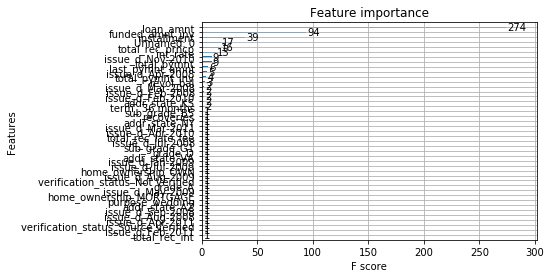

In [12]:
xb.plot_importance(model)

In [13]:
import pickle

# save model to file
pickle.dump(model, open("lendingclub.pickle.dat", "wb"))

In [ ]:
boosting_rounds = [3,5,7,9,15,20,25,30]
untunedParams = {"objective":"reg:linear","nfold":"3"}
metric_values = []

for rounds in boosting_rounds:
    cv_result = xb.cv(params=untunedParams, dtrain=dTrainMatrix, metrics='mae', num_boost_round=rounds, as_pandas=True)
    metric_values.append(cv_result['test-mae-std'].tail().values[-1])
    
df = pd.DataFrame(data=list(zip(boosting_rounds, metric_values)), columns=['Boosting Rounds','MAE'])
print (df)